# Demostration

## 1. CLIP+CosSim

In [1]:
%cd /work/adapting-CLIP-VGPs/

/work/adapting-CLIP-VGPs


In [2]:
from models.vgp_vit import VGPViT
import torch

GPU = 3
args = {
    'model': 'vit14',
    'alpha': 0.75,
    'aggregation': 'mean',
    'n_segments': list(range(100, 601, 50)),
    'temperature': 0.02,
    'upsample': 2,
    'start_block': 0,
    'compactness': 50,
    'sigma': 0,
}

model = VGPViT(**args).to(GPU)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


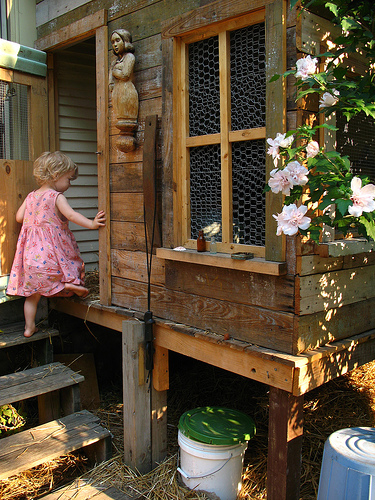

In [3]:
from PIL import Image
import numpy as np

img_path = 'data/flickr/flickr30k_images/1000268201.jpg'
img = Image.open(img_path).convert("RGB")
img_data = np.array(img)

img.show()

In [4]:
'''
Captions:
1000268201.jpg| 0| A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201.jpg| 1| A little girl in a pink dress going into a wooden cabin .
1000268201.jpg| 2| A little girl climbing the stairs to her playhouse .
1000268201.jpg| 3| A little girl climbing into a wooden playhouse 
1000268201.jpg| 4| A girl going into a wooden building .
'''
phrases = ['playhouse', 'building']


In [5]:
import torch

img_tensor = torch.from_numpy(img_data).to(GPU)
masks = model.get_masks(img_tensor)

/work/adapting-CLIP-VGPs/models/vgp_vit.py:56: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  np.float32)/255., n_segments=n, compactness=self.compactness, sigma=self.sigma)


In [6]:
masks = torch.from_numpy(masks.astype(np.bool)).to(GPU)
preprocessed_image = model.model.preprocess(Image.fromarray(img_tensor.cpu().numpy())).unsqueeze(0).to(GPU)

In [10]:
attn_mask = model.model.masks_to_attn_map(masks)
print(attn_mask.shape)

torch.Size([3832, 4856])


In [ ]:
heatmaps = model(img_data, phrases)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(heatmaps[0])
plt.axis('off')

In [ ]:
plt.imshow(heatmaps[1])
plt.axis('off')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# plt.imshow(np.abs(heatmaps[0]-heatmaps[1]))
# mask = np.abs(heatmaps[0]-heatmaps[1]) > 0.5
# np.sum(mask)

similarity_score = cosine_similarity(heatmaps[0].reshape(1, -1), heatmaps[1].reshape(1, -1))[0, 0]
print(similarity_score)

In [ ]:
import numpy as np
from scipy.special import kl_div
from scipy.stats import entropy

def kl_divergence(p, q):
    # Compute the KL divergence between two probability distributions p and q
    kl_divergence = entropy(p, q)
    return kl_divergence

# Normalize the attention maps to be probability distributions (sum to 1)
attention_map1, attention_map2 = heatmaps
attention_map1 = attention_map1 / np.sum(attention_map1)
attention_map2 = attention_map2 / np.sum(attention_map2)

# Calculate the KL divergence between the two attention maps
kl_div_value = kl_divergence(attention_map1, attention_map2)

print(f"KL Divergence between the two attention maps: {kl_div_value<0.1}")


In [ ]:
import cv2
import numpy as np
from skimage import metrics

def compare_heatmaps(heatmap1, heatmap2):
    # Ensure both heatmaps have the same dimensions
    if heatmap1.shape != heatmap2.shape:
        raise ValueError("Heatmaps must have the same dimensions")

    # # Convert heatmaps to 8-bit images (scaling them between 0 and 255)
    # heatmap1_scaled = cv2.normalize(heatmap1, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # heatmap2_scaled = cv2.normalize(heatmap2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Compute SSIM
    ssim = metrics.structural_similarity(heatmap1, heatmap2)

    # Compute MSE
    mse = np.mean((heatmap1 - heatmap2) ** 2)

    return ssim, mse

# Load your heatmaps (replace 'heatmap1.png' and 'heatmap2.png' with your actual file paths)
heatmap1, heatmap2 = heatmaps

# Compare the heatmaps
ssim, mse = compare_heatmaps(heatmap1, heatmap2)
print(ssim, mse)

# You can set a threshold for similarity, depending on your requirements
threshold_ssim = 0.9
threshold_mse = 1000

if ssim >= threshold_ssim and mse <= threshold_mse:
    print("The heatmaps describe the same object.")
else:
    print("The heatmaps describe different objects.")



In [ ]:
img_path = 'data/flickr/flickr30k_images/1016887272.jpg'
img = Image.open(img_path).convert("RGB")
img_data = np.array(img)
# img.show()

phrases = ['Several climbers', 'A group of people']
heatmaps = model(img_data, phrases)

import matplotlib.pyplot as plt

plt.imshow(heatmaps[0])
plt.axis('off')

In [ ]:
plt.imshow(heatmaps[1])
plt.axis('off')

from sklearn.metrics.pairwise import cosine_similarity

similarity_score = cosine_similarity(heatmaps[0].reshape(1, -1), heatmaps[1].reshape(1, -1))[0, 0]
print(similarity_score)

In [ ]:
img_path = 'data/flickr/flickr30k_images/1016887272.jpg'
img = Image.open(img_path).convert("RGB")
img_data = np.array(img)
# img.show()

phrases = ['the beach', 'the ocean']
heatmaps = model(img_data, phrases)

import matplotlib.pyplot as plt

plt.imshow(heatmaps[0])
plt.axis('off')

In [ ]:
plt.imshow(heatmaps[1])
plt.axis('off')

from sklearn.metrics.pairwise import cosine_similarity

similarity_score = cosine_similarity(heatmaps[0].reshape(1, -1), heatmaps[1].reshape(1, -1))[0, 0]
print(similarity_score)

In [ ]:
img_path = 'data/flickr/flickr30k_images/1016887272.jpg'
img = Image.open(img_path).convert("RGB")
img_data = np.array(img)
# img.show()

phrases = ['Two children', 'Two young , wet boys']
heatmaps = model(img_data, phrases)

import matplotlib.pyplot as plt

plt.imshow(heatmaps[0])
plt.axis('off')

In [ ]:
plt.imshow(heatmaps[1])
plt.axis('off')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_score = cosine_similarity(heatmaps[0].reshape(1, -1), heatmaps[1].reshape(1, -1))[0, 0]
print(similarity_score)

## 2. CLIP+CNN

In [1]:
%cd /work/adapting-CLIP-VGPs/

from models.vgp_vit import VGPViT
import torch

args = {
    'model': 'vit14',
    'alpha': 0.75,
    'aggregation': 'mean',
    'n_segments': list(range(100, 601, 50)),
    'temperature': 0.02,
    'upsample': 2,
    'start_block': 0,
    'compactness': 50,
    'sigma': 0,
}

# from PIL import Image
# import numpy as np

# img_path = 'data/flickr/flickr30k_images/1000268201.jpg'
# img = Image.open(img_path).convert("RGB").resize((224,224))
# img_data = np.array(img)

# img.show()

# '''
# Captions:
# 1000268201.jpg| 0| A child in a pink dress is climbing up a set of stairs in an entry way .
# 1000268201.jpg| 1| A little girl in a pink dress going into a wooden cabin .
# 1000268201.jpg| 2| A little girl climbing the stairs to her playhouse .
# 1000268201.jpg| 3| A little girl climbing into a wooden playhouse 
# 1000268201.jpg| 4| A girl going into a wooden building .
# '''
# phrases = ['girl', 'child']

/work/adapting-CLIP-VGPs


In [2]:
from utils.vgp_data import FlickrVGPsDataset
from torch.utils.data import DataLoader

train_dataset = FlickrVGPsDataset(data_type='train')

In [4]:
import clip

phrase1 = clip.tokenize(['Two people']).cuda()
phrase2 = clip.tokenize(['A group of people']).cuda()
print(phrase1)
print(phrase2)

pairx = torch.cat((phrase1, phrase2), dim=0)
pairy = clip.tokenize(['Two people', 'A group of people']).cuda()
print(pairx)
print(pairy)

tensor([[49406,  1237,  1047, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0',
       dtype=torch.int32)
tensor([[49406,   320,  1771,   539,  1047, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0

In [3]:
torch.manual_seed(0)
batch_size = 100

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

batch_iter = iter(train_loader)
batch = next(batch_iter)
indices = batch['idx']
image_indices = batch['image_idx']
images = batch['image']
phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
labels = batch['label']

In [4]:
image_indices

['3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '3359636318',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '6959556104',
 '69595561

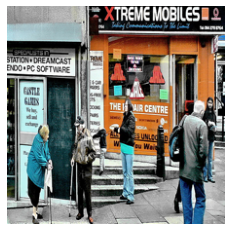

In [4]:
import matplotlib.pyplot as plt

def show(img_tensor):
    # Assuming img_data is your uint8 PyTorch tensor image
    if torch.is_tensor(img_tensor) and img_tensor.dtype == torch.uint8:
        # Convert the tensor to a NumPy array and normalize if necessary
        img_array = img_tensor.numpy()

        # If the image has channels (e.g., RGB), transpose the dimensions
        if img_array.shape[0] == 3:
            img_array = img_array.transpose(1, 2, 0)

        # Display the image using matplotlib
        plt.imshow(img_array)
        plt.axis('off')
        plt.show()
    else:
        print("Invalid image data.")

show(images[0])

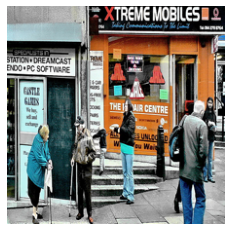

In [6]:
img = images[0]
phrases = phrase_pairs[0]

# print(img, phrases)
from skimage.segmentation import slic
import numpy as np

def get_masks(im):
    masks = []

    n_segments = list(range(100, 601, 50))
    compactness = 50
    sigma = 0

    # Do SLIC with different number of segments so that it has a hierarchical scale structure
    # This can average out spurious activations that happens sometimes when the segments are too small
    for n in n_segments:
        segments_slic = slic(im.astype(
            np.float32)/255., n_segments=n, compactness=compactness, sigma=sigma)
        for i in np.unique(segments_slic):
            mask = segments_slic == i
            masks.append(mask)
    masks = np.stack(masks, 0)
    return masks

show(img)

In [9]:
vit, preprocess = clip.load(
                "ViT-L/14",
                device=0    
            )

In [15]:
from PIL import Image

prep = preprocess(Image.fromarray(img.cpu().numpy()))


tensor(-1.7923)

In [7]:
map_model = VGPViT(**args).cuda()
heatmaps = map_model(img, phrases)

/work/adapting-CLIP-VGPs/models/vgp_vit.py:56: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  np.float32)/255., n_segments=n, compactness=self.compactness, sigma=self.sigma)


Two people


(-0.5, 223.5, 223.5, -0.5)

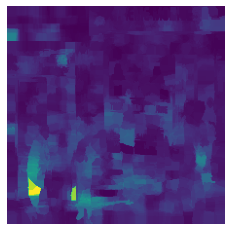

In [9]:
print(phrases[0])
plt.imshow(heatmaps[0])
plt.axis('off')

In [2]:
import numpy as np
import os
import blosc

def save_heatmaps(heatmaps, file_path, compress=False):
    # Convert the heatmaps to a compressed format if required
    if compress:
        compressed_heatmaps = [blosc.compress(np.ascontiguousarray(hm), cname='zstd', clevel=5) for hm in heatmaps]
    else:
        compressed_heatmaps = heatmaps

    # Save using np.savez_compressed for efficient storage
    np.savez_compressed(file_path, *compressed_heatmaps)

def load_heatmaps(file_path, compress=False):
    data = np.load(file_path, allow_pickle=True)
    heatmaps = [data[f'arr_{i}'] for i in range(len(data))]
    
    if compress:
        heatmaps = [blosc.decompress(hm) for hm in heatmaps]

    return heatmaps

# Usage Example
# save_heatmaps(heatmaps[0], 'heatmap0.npz')


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:682: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype object cannot be converted to float

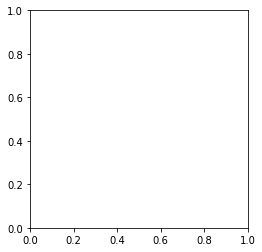

In [6]:
import matplotlib.pyplot as plt
hm = load_heatmaps('/work/adapting-CLIP-VGPs/data/flickr/heatmaps/train/2859601137/a navy blue apron.npz')
plt.imshow(hm)
plt.axis('off')

In [8]:
hm

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00126547,
        0.01156763, 0.0175339 , 0.01912391, 0.01975096, 0.02062444,
        0.02062444, 0.02062444, 0.02062444, 0.02062444, 0.02062444,
        0.01974279, 0.01714708, 0.01457625, 0.01457625, 0.01457625,
        0.01457625, 0.01225938, 0.01249441, 0.01249441, 0.01249441,
        0.01107821, 0.008334  , 0.008334  , 0.008334  , 0.00718222,
        0.00718222, 0.0042379 , 0.00176015, 0.00176015, 0.00176015,
        0.00176015, 0.00155017, 0.00155017, 0.00155017, 0.00155017,
        0.00155017, 0.00155017, 0.00113637, 0.00126571, 0.00126571,
        0.00126571, 0.00126571, 0.00116766, 0.00116766, 0.00116766,
        0.00116766, 0.00116766, 0.00116766, 0.00163262, 0.00133595,
        0.00196968, 0.00196968, 0.00196968, 0.00196968, 0.00302884,
        0.00390064, 0.00390064, 0.00585909, 0.00599369, 0.00599369,
        0.00700158, 0.00700158, 0.01056553, 0.01

A group of people


(-0.5, 223.5, 223.5, -0.5)

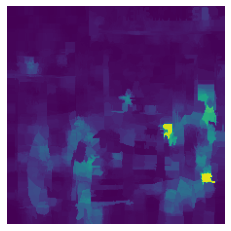

In [11]:
print(phrases[1])
plt.imshow(heatmaps[1])
plt.axis('off')

In [39]:
print(heatmaps[0]==hm[0])

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


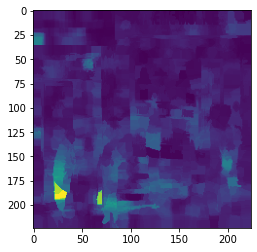

In [37]:
hm = map_model(img, [phrases[0]])
plt.imshow(hm[0])

In [29]:
DATA_ROOT = f'/work/adapting-CLIP-VGPs/data/flickr/heatmaps/train/'

file_names = os.listdir(f'{DATA_ROOT}')
print(file_names)

['2.pt', '0.pt', '3.pt', '4.pt', '1.pt', '5.pt', '6.pt', '8.pt', '12.pt', '18.pt', '9.pt', '10.pt', '7.pt', '11.pt', '24.pt', '14.pt', '17.pt', '20.pt', '16.pt', '22.pt', '15.pt', '21.pt', '13.pt', '23.pt', '29.pt', '26.pt', '28.pt', '27.pt', '30.pt', '19.pt', '36.pt', '25.pt', '35.pt', '32.pt', '34.pt', '33.pt', '41.pt', '42.pt', '38.pt', '39.pt', '31.pt', '48.pt', '40.pt', '54.pt', '47.pt', '44.pt', '46.pt', '60.pt', '45.pt', '37.pt', '50.pt', '66.pt', '51.pt', '43.pt', '53.pt', '56.pt', '62.pt', '72.pt', '78.pt', '52.pt', '57.pt', '49.pt', '59.pt', '65.pt', '68.pt', '58.pt', '63.pt', '69.pt', '55.pt', '71.pt', '64.pt', '70.pt', '84.pt', '75.pt', '81.pt', '61.pt', '74.pt', '80.pt', '77.pt', '76.pt', '82.pt', '90.pt', '67.pt', '96.pt', '87.pt', '86.pt', '83.pt', '73.pt', '79.pt', '88.pt', '93.pt', '89.pt', '92.pt', '95.pt', '94.pt', '99.pt', '85.pt', '98.pt', '91.pt', '97.pt']


### CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class HeatMapsComparator(nn.Module):
    def __init__(self, pretrained_model):
        print('Init CNN comparator')
        super(HeatMapsComparator, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 112 * 112 * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        self.map_model = pretrained_model
        self.thres = nn.Parameter(torch.tensor([0.5]))
    
    def predict(self, x):
        return x > self.thres

    def forward(self, img, phrases):
        x1,x2 = self.map_model(img, phrases)
        # Convert NumPy arrays to PyTorch tensors
        x1 = torch.from_numpy(x1).unsqueeze(0).unsqueeze(0).cuda()
        x2 = torch.from_numpy(x2).unsqueeze(0).unsqueeze(0).cuda()
        x1 = self.pool(self.relu(self.conv1(x1)))
        x2 = self.pool(self.relu(self.conv1(x2)))
        x1 = x1.view(-1, 64 * 112 * 112)
        x2 = x2.view(-1, 64 * 112 * 112)
        x = torch.cat((x1, x2), dim=1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [6]:
map_model = VGPViT(**args).cuda()
for param in map_model.parameters():
    param.requires_grad = False
model = HeatMapsComparator(map_model).cuda()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Init CNN comparator


In [ ]:
map_model = VGPViT(**args).cuda()
heatmaps = map_model(img, phrases)

In [14]:
from tqdm import tqdm
outputs = [model(image, phrases) for image, phrases in tqdm(zip(images, phrase_pairs))]

0it [00:00, ?it/s]/work/adapting-CLIP-VGPs/models/vgp_vit.py:54: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  np.float32)/255., n_segments=n, compactness=self.compactness, sigma=self.sigma)
100it [01:31,  1.10it/s]


In [ ]:
output_tensor = torch.cat(outputs)
output_tensor

In [45]:
label_tensor = labels.float().unsqueeze(1).cuda()
label_tensor

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

In [46]:
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()

loss = criterion(output_tensor, label_tensor)

In [54]:
loss.item()

0.9026926159858704

In [53]:
preds = torch.tensor([model.predict(output) for output in outputs])
torch.sum(preds)

tensor(100)

## 3. CLIP

In [1]:
%cd /work/adapting-CLIP-VGPs/

from models.vgp_vit import VGPViT
import torch

args = {
    'model': 'vit14',
    'alpha': 0.75,
    'aggregation': 'mean',
    'n_segments': list(range(100, 601, 50)),
    'temperature': 0.02,
    'upsample': 2,
    'start_block': 0,
    'compactness': 50,
    'sigma': 0,
}

/work/adapting-CLIP-VGPs


In [2]:
from utils.vgp_data import FlickrVGPsDataset
from torch.utils.data import DataLoader

test_dataset = FlickrVGPsDataset(data_type='test')

In [5]:
img_path = 'data/flickr/flickr30k_images/1000268201.jpg'
pil_img = Image.open(img_path).convert("RGB")
img = np.array(pil_img)
'''
# Captions:
1000268201.jpg| 0| A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201.jpg| 1| A little girl in a pink dress going into a wooden cabin .
1000268201.jpg| 2| A little girl climbing the stairs to her playhouse .
1000268201.jpg| 3| A little girl climbing into a wooden playhouse 
1000268201.jpg| 4| A girl going into a wooden building .
'''

phrases = ['girl', 'child']

import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')

NameError: name 'Image' is not defined

## 4. Siamese

In [1]:
%cd /work/adapting-CLIP-VGPs/
from utils.vgp_data import FlickrVGPsDataset
from torch.utils.data import DataLoader

train_dataset = FlickrVGPsDataset(data_type='train')

from models.siamese import SiameseNet
model = SiameseNet().cuda()

/work/adapting-CLIP-VGPs


In [2]:
model

SiameseNet(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (liner): Sequential(
    (0): Linear(in_features=20736, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)

In [3]:
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

batch_iter = iter(train_loader)
batch = next(batch_iter)
indices = batch['idx']
image_paths = batch['image_idx']
images = batch['image']
phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
labels = batch['label']

In [12]:
import torch
import numpy as np
from tqdm import tqdm

def contains_non_ascii(s):
    return any(ord(c) > 127 for c in s)
def replace_non_ascii(s):
    return ''.join(c if ord(c) < 128 else '?' for c in s)

def load_heatmap_tensor(gpu, dataroot, img_path, phrase):
    heatmap_path = f'{dataroot}{img_path}/{phrase}.npz'
    heatmap_path = replace_non_ascii(heatmap_path) if contains_non_ascii(heatmap_path) else heatmap_path
    data = np.load(heatmap_path, allow_pickle=True)
    heatmap = np.array([data[f'arr_{i}'] for i in range(len(data))])
    # heatmap_tensor = torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0).to(gpu)
    return heatmap

DATA_ROOT = f'/work/adapting-CLIP-VGPs/data/flickr/heatmaps/train/'

left_heatmaps = [load_heatmap_tensor(0, DATA_ROOT, img_path, phrases[0]) for img_path, phrases in tqdm(zip(image_paths, phrase_pairs))]
right_heatmaps = [load_heatmap_tensor(0, DATA_ROOT, img_path, phrases[1]) for img_path, phrases in tqdm(zip(image_paths, phrase_pairs))]

100it [00:08, 11.70it/s]
100it [00:07, 12.94it/s]


In [20]:
left_tensor = torch.tensor(left_heatmaps).unsqueeze(1).cuda()
right_tensor = torch.tensor(right_heatmaps).unsqueeze(1).cuda()

In [21]:
outputs = model(left_tensor, right_tensor)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [29]:
criterion = torch.nn.BCEWithLogitsLoss()

label_tensor = labels.float().cuda()

loss = criterion(outputs, label_tensor.unsqueeze(1))
print(loss)

tensor(0.6893, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


In [50]:
y_pred = torch.sigmoid(outputs)
y_pred = y_pred > 0.5
print(y_pred)

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False

In [54]:
(y_pred.squeeze(1) == label_tensor).sum().item()

60

In [8]:
def contains_non_ascii(s):
    return any(ord(c) > 127 for c in s)
def replace_non_ascii(s):
    return ''.join(c if ord(c) < 128 else '?' for c in s)

DATA_ROOT = f'/work/adapting-CLIP-VGPs/data/flickr/heatmaps/train/'
img_path = f'{DATA_ROOT}{img_path}'

heatmap1_path = f'{img_path}/{phrases[0]}.npz'
heatmap2_path = f'{img_path}/{phrases[1]}.npz'

heatmap1_path = replace_non_ascii(heatmap1_path) if contains_non_ascii(heatmap1_path) else heatmap1_path
heatmap2_path = replace_non_ascii(heatmap2_path) if contains_non_ascii(heatmap2_path) else heatmap2_path

In [57]:
import numpy as np
import blosc

def save_heatmaps(heatmaps, file_path, compress=False):
    # Convert the heatmaps to a compressed format if required
    if compress:
        compressed_heatmaps = [blosc.compress(np.ascontiguousarray(hm), cname='zstd', clevel=5) for hm in heatmaps]
    else:
        compressed_heatmaps = heatmaps

    # Save using np.savez_compressed for efficient storage
    np.savez_compressed(file_path, *compressed_heatmaps)

def load_heatmaps(file_path, compress=False):
    data = np.load(file_path, allow_pickle=True)
    heatmaps = [data[f'arr_{i}'] for i in range(len(data))]
    
    if compress:
        heatmaps = [blosc.decompress(hm) for hm in heatmaps]

    return np.array(heatmaps)

heatmap1 = load_heatmaps(heatmap1_path)
heatmap2 = load_heatmaps(heatmap2_path)

In [47]:
print(heatmap1.shape)

(224, 224)


(-0.5, 223.5, 223.5, -0.5)

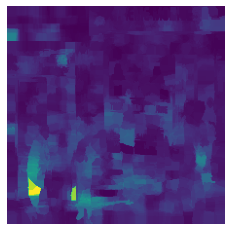

In [48]:
import matplotlib.pyplot as plt
plt.imshow(heatmap1)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

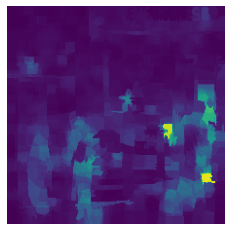

In [49]:
import matplotlib.pyplot as plt
plt.imshow(heatmap2)
plt.axis('off')

In [51]:
import torch

heatmap1_tensor = torch.from_numpy(heatmap1).unsqueeze(0).unsqueeze(0).cuda()
heatmap2_tensor = torch.from_numpy(heatmap2).unsqueeze(0).unsqueeze(0).cuda()

print(heatmap1_tensor.shape)

torch.Size([1, 1, 224, 224])


In [55]:
output_tensor = model(heatmap1_tensor, heatmap2_tensor)

In [56]:
print(output_tensor.item())

0.11297784745693207


In [61]:
pred = torch.sigmoid(output_tensor)
print(pred)
print(torch.argmax(pred))

tensor([[0.5282]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0, device='cuda:0')


### Heatmap dataset

In [2]:
%cd /work/adapting-CLIP-VGPs/
from utils.heatmap_data import VGPsHeatmapsDataset

heatmap_dataset = VGPsHeatmapsDataset(split="train")
num_samples = 500000
heatmap_dataset.image_idices = heatmap_dataset.image_idices[:num_samples]

/work/adapting-CLIP-VGPs


In [13]:
from torch.utils.data import DataLoader

batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

batch_iter = iter(heatmap_loader)
batch = next(batch_iter)
image_paths = batch['img_idx']
phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
left_heatmaps = batch['left_heatmap']
right_heatmaps = batch['right_heatmap']
labels = batch['label']

In [23]:
labels

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False,  True, False,  True, False, False,  True, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False, False, False, False,
         True,  True, False,  True, False, False, False, False, False, False,
        False, False,  True,  True,  True, False, False, False, False, False,
        False, False,  True, False, False,  True, False, False, False, False])

In [4]:
from torch.utils.data import random_split
import torch
generator=torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(heatmap_dataset, [int(num_samples*0.8), int(num_samples*0.2)], generator=generator)

In [5]:
batch_size = 100

heatmap_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

batch_iter = iter(heatmap_loader)
batch = next(batch_iter)
image_paths = batch['img_idx']
left_heatmaps = batch['left_heatmap']
right_heatmaps = batch['right_heatmap']
labels = batch['label']

In [5]:
from models.siamese import SiameseNet
model = SiameseNet().to(1)

In [9]:
left_tensor = left_heatmaps.unsqueeze(1).to(1)
right_tensor = right_heatmaps.unsqueeze(1).to(1)
label_tensor = labels.float().unsqueeze(1).to(1)

In [12]:
x = model.conv(left_tensor)
# x = x.view(x.size()[0], -1)
print(x.shape)

torch.Size([100, 256, 21, 21])


In [16]:
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
model.train()

with torch.set_grad_enabled(True):
    outputs = model(left_tensor, right_tensor)
    loss = criterion(outputs, label_tensor)
    preds = torch.sigmoid(outputs) > 0.5



In [17]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}, grad: {param.grad}")

conv.0.weight, grad: None
conv.0.bias, grad: None
conv.3.weight, grad: None
conv.3.bias, grad: None
conv.6.weight, grad: None
conv.6.bias, grad: None
conv.9.weight, grad: None
conv.9.bias, grad: None
liner.0.weight, grad: None
liner.0.bias, grad: None
out.weight, grad: tensor([[0.0259, 0.0213, 0.0155,  ..., 0.0228, 0.0216, 0.0201]],
       device='cuda:0')
out.bias, grad: tensor([0.3835], device='cuda:0')


### Checkpoint

In [3]:
import torch

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/checkpoint10.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

In [2]:
print(checkpoint['model_state_dict'])

OrderedDict([('module.conv.0.weight', tensor([[[[-0.1608,  0.0789, -0.1968,  ..., -0.1587,  0.1292, -0.1788],
          [-0.0804,  0.1725, -0.2197,  ...,  0.1293,  0.0298,  0.0263],
          [-0.1405,  0.1739, -0.1472,  ...,  0.0669, -0.1097,  0.0070],
          ...,
          [ 0.0444,  0.1586, -0.0262,  ...,  0.1636,  0.1710,  0.0554],
          [-0.1985,  0.0515, -0.1156,  ..., -0.2005, -0.0706,  0.1114],
          [-0.0147, -0.1908, -0.1602,  ..., -0.2378, -0.1892,  0.1480]]],


        [[[-0.1180,  0.0611, -0.0557,  ..., -0.1110,  0.2427,  0.1350],
          [ 0.0680,  0.1519, -0.0980,  ..., -0.1242, -0.0180, -0.0471],
          [ 0.0693, -0.1393,  0.2093,  ..., -0.0884,  0.0105,  0.0672],
          ...,
          [-0.1252,  0.1636,  0.0093,  ...,  0.2531,  0.1244, -0.0481],
          [-0.1626, -0.2339,  0.1368,  ...,  0.1219, -0.0316,  0.0020],
          [ 0.2469, -0.1191, -0.1388,  ...,  0.0340,  0.1360, -0.1948]]],


        [[[-0.0378,  0.0650,  0.1441,  ..., -0.0375, -0.0360

In [9]:
from models.siamese import SiameseNet
from collections import OrderedDict
model = SiameseNet()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v.cpu()

In [10]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [11]:
model

SiameseNet(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (liner): Sequential(
    (0): Linear(in_features=112896, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)

In [14]:
%cd /work/adapting-CLIP-VGPs/
from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

batch_iter = iter(heatmap_loader)
batch = next(batch_iter)
image_paths = batch['img_idx']
phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
left_heatmaps = batch['left_heatmap']
right_heatmaps = batch['right_heatmap']
labels = batch['label']

left_tensor = left_heatmaps.unsqueeze(1)
right_tensor = right_heatmaps.unsqueeze(1)
label_tensor = labels.float().unsqueeze(1)

/work/adapting-CLIP-VGPs


In [15]:
outputs = model(left_tensor, right_tensor)
print(outputs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[  1.1294],
        [ -4.3657],
        [ -5.8280],
        [ -3.9777],
        [ -7.0367],
        [ -3.8206],
        [ -4.5894],
        [ -2.7192],
        [ -7.2681],
        [ -7.5175],
        [ -3.3362],
        [ -4.5927],
        [ -3.8511],
        [ -6.9363],
        [ -2.7936],
        [ -4.0518],
        [ -4.5229],
        [ -4.9184],
        [ -1.0130],
        [ -1.9641],
        [ -2.5754],
        [ -3.0072],
        [ -6.2195],
        [ -5.3511],
        [ -4.1920],
        [ -5.7616],
        [ -2.7100],
        [ -4.0977],
        [ -2.7314],
        [ -3.4283],
        [ -2.5754],
        [ -5.9004],
        [ -5.8335],
        [ -6.2195],
        [ -5.9369],
        [ -4.1920],
        [ -6.0568],
        [ -2.7100],
        [ -8.0290],
        [ -3.6478],
        [ -2.7314],
        [ -5.4310],
        [ -2.7239],
        [ -3.3711],
        [ -1.2061],
        [ -4.6586],
        [ -5.8626],
        [ -2.3320],
        [ -9.8050],
        [ -3.7729],


In [17]:
probs = torch.sigmoid(outputs)
preds = probs > 0.5

In [21]:
corrects = torch.sum(preds.squeeze(1) == label_tensor.squeeze(1)).item()
print(corrects)

89


In [23]:
preds[10].item()

False

In [19]:
probs[0].item()

0.7557303309440613

# Evaluation

In [1]:
import pandas as pd
from sklearn.metrics import recall_score

demo_res = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/demo_results.csv')
pred = demo_res['pred']

FP = (pred==True).sum()
FN = len(pred) - FP

test_set = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/phrase_pair_remove_trivial_match_test.csv')
ytrue = test_set['ytrue']
TP = (ytrue==True).sum() - FN
TN = len(ytrue) - TP - FN - FP

Confusion_matrix = [[TN, FP], [FN, TP]]

prec = TP/(TP+FP)
rec = TP/(TP+FN)
f1 = 2*(prec*rec)/(prec+rec)

print(f'Prec = {prec}')
print(f'Rec = {rec}')
print(f'F1-score = {f1}')

Prec = 0.575344563552833
Rec = 0.6957407407407408
F1-score = 0.6298407376362113


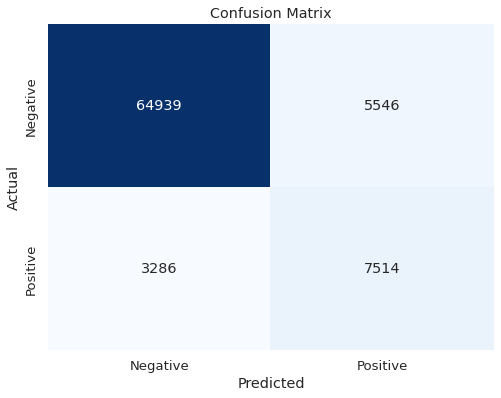

Precision: 0.575344563552833
Recall: 0.6957407407407408
F1 Score: 0.6298407376362113


In [2]:
import pandas as pd
from sklearn.metrics import recall_score

val_results = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/test_results.csv')
pred = val_results['pred']
gt = val_results['gt']

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


In [17]:
import pandas as pd
from sklearn.metrics import recall_score

val_results = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/val_results.csv')
pred = val_results['pred']
gt = val_results['gt']

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/work/adapting-CLIP-VGPs/data/flickr/val_results.csv'

# Analys

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.575344563552833
Recall: 0.6957407407407408
F1 Score: 0.6298407376362113


In [19]:
plot = sns.displot(
    val_results,
    x="sim_score",
    bins=20,
    hue="gt",
    # multiple="stack"
)
plot.set_xlabels('Attention Map Cosine Similarity')

ValueError: Could not interpret value `gt` for parameter `hue`

In [ ]:
print(len(val_results[(val_results['sim_score']<=0.7) & (val_results['gt']==True)]))

In [ ]:
demo_res = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/demo_results.csv')

failed_cases = demo_res[(demo_res['gt'] == True) & (demo_res['pred'] == False)]

print(failed_cases)

In [ ]:
# Replace 'column_name' with the name of your column
column_name = 'sim_score'

# Create a histogram
plt.hist(failed_cases[column_name], bins=20, color='skyblue', edgecolor='black')  # You can adjust the number of bins and color

# Set labels and title
plt.xlabel('Cosine similarity score')
plt.ylabel('Number of failed queries')
plt.title(f'Distribution of Sim_score in failed VGP dectection')

# Show the plot
plt.show()


In [ ]:
val_results = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/val_results.csv')
nonVGP_cases = val_results[val_results['gt'] == False]

# Replace 'column_name' with the name of your column
column_name = 'sim_score'

# Create a histogram
plt.hist(nonVGP_cases[column_name], bins=20, color='skyblue', edgecolor='black')  # You can adjust the number of bins and color

# Set labels and title
plt.xlabel('Cosine similarity score')
plt.ylabel('Number of failed queries')
plt.title(f'Distribution of Sim_score in non-VGP cases')

# Show the plot
plt.show()

In [ ]:
dataset = pd.read_csv('/work/adapting-CLIP-VGPs/data/flickr/phrases_data/phrase_pair_remove_trivial_match_test.csv')
# print(dataset)
failed_samples = pd.merge(failed_cases, dataset[['Unnamed: 0','image']], left_on='dataset_idx', right_on='Unnamed: 0', how='inner')
print(failed_samples[:2])

In [ ]:
import random

random.seed(0)
num_samples = 10
selected_unique_values = random.sample(list(failed_samples['image'].unique()), num_samples)
# print(selected_unique_values)

random_samples = failed_samples[failed_samples['image'].isin(selected_unique_values)]
print(random_samples[:3])

In [ ]:
from PIL import Image
import numpy as np
import pandas as pd
from models.vgp_vit import VGPViT

args = {
    'model': 'vit14',
    'alpha': 0.75,
    'aggregation': 'mean',
    'n_segments': list(range(100, 601, 50)),
    'temperature': 0.02,
    'upsample': 2,
    'start_block': 0,
    'compactness': 50,
    'sigma': 0,
}

model = VGPViT(**args).cuda()

In [ ]:
from tqdm import tqdm
import ast

images = random_samples['image']
phrases = [ast.literal_eval(txtpair) for txtpair in random_samples['phrases']]
sim_scores = random_samples['sim_score']

for imgidx, txtpair, sim_score in tqdm(zip(images, phrases, sim_scores)):
    # print(sample)
    img_path = f'data/flickr/flickr30k_images/{imgidx}.jpg'
    img = Image.open(img_path).convert("RGB")
    
    img_data = np.array(img)

    heatmaps = model(img_data, txtpair)
    
    # img.resize((224, 224)).show()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))  # Adjust the figure size as needed
    # Plot the first array on the first subplot
    ax1.imshow(np.array(img.resize((224,224))))
    ax1.set_title('Input image')
    # Remove the subplot grid
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

    # Plot the first array on the first subplot
    ax2.imshow(heatmaps[0])
    ax2.set_title(txtpair[0])
    # Remove the subplot grid
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    # Plot the second array on the second subplot
    ax3.imshow(heatmaps[1])
    ax3.set_title(txtpair[1])
    # Remove the subplot grid
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])

    # Show the combined plot
    # plt.tight_layout()
    fig.suptitle(f'Heatmaps cos similarity = {sim_score}').set_position([0.5, 0])
    plt.show()
    
    # size = 224
    # spaceBetween = 100
    # combined_image = Image.new('RGB', (size*3 + int(spaceBetween*1.5), size))
    # combined_image.paste(img.resize((224, 224)), (0, 0))
    # combined_image.paste(heatmap1, (size+spaceBetween, 0))
    # combined_image.paste(heatmap2, (size*2+int(spaceBetween*1.5), 0))

    # heatmap_samples.append([img_idx, phrases, combined_image])
    

## Siamese eval

In [2]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm

checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/checkpoint3.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

from models.siamese import SiameseNet
from collections import OrderedDict
model = SiameseNet()

# # Adjust for 'DataParallel' consistency
new_state_dict = OrderedDict()
for k, v in checkpoint['model_state_dict'].items():
    prefix = 'module.'
    name = k[len(prefix):]  # add `module.` prefix
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.cuda()
model.eval()

from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_results = []

with torch.no_grad():
    for batch in tqdm(heatmap_loader):
        image_paths = batch['img_idx']
        phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
        left_heatmaps = batch['left_heatmap']
        right_heatmaps = batch['right_heatmap']
        labels = batch['label']
        
        left_tensor = left_heatmaps.unsqueeze(1).cuda()
        right_tensor = right_heatmaps.unsqueeze(1).cuda()
        label_tensor = labels.float().unsqueeze(1).cuda()
        
        outputs = model(left_tensor, right_tensor)
        # loss = criterion(outputs, label_tensor)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        TP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        FP = ((preds.squeeze(1) == 1) & (label_tensor.squeeze(1) == 0)).float().sum().item()
        FN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 1)).float().sum().item()
        TN = ((preds.squeeze(1) == 0) & (label_tensor.squeeze(1) == 0)).float().sum().item()            
                
        acc = (TP + TN) / len(image_paths)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
        print(f'Batch prec:{prec}')
        print(f'Batch rec:{rec}')

        for i in range(len(image_paths)):
            test_results.append([image_paths[i], phrase_pairs[i], probs[i].item(), preds[i].item(), labels[i].item()])             

/work/adapting-CLIP-VGPs


  0%|          | 0/813 [00:03<?, ?it/s]


NameError: name 'TN' is not defined

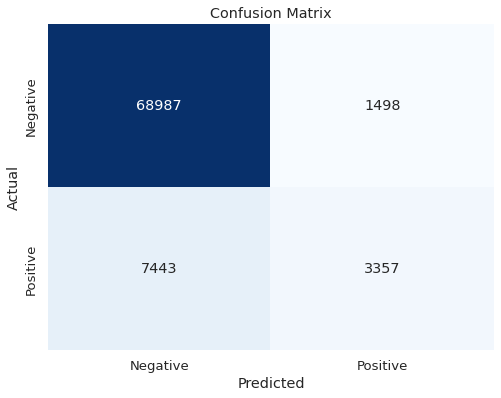

Accuracy: 0.8900043058374854
Precision: 0.6914521112255407
Recall: 0.31083333333333335
F1 Score: 0.42887256467582247


In [ ]:
import pandas as pd

# val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
pred = [row[3] for row in test_results]
gt = [row[4] for row in test_results]

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Replace actual_labels and predicted_labels with your own data
cm = confusion_matrix(gt, pred)

# Define class labels
class_labels = ['Negative', 'Positive']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(gt, pred)

# Calculate recall
recall = recall_score(gt, pred)

# Calculate F1 score
f1 = f1_score(gt, pred)

# Calculate accuracy
acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

print(f'Accuracy: {acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

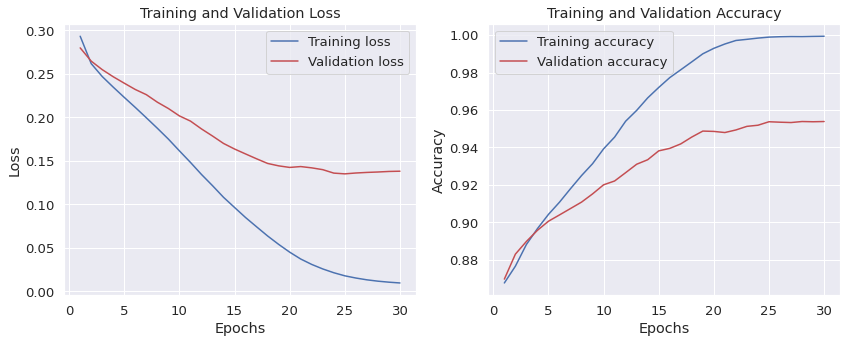

In [ ]:
import matplotlib.pyplot as plt
import json

# Load data from JSON
with open('/work/adapting-CLIP-VGPs/checkpoints/training_history.json', 'r') as file:
    data = json.load(file)

train_loss = data['train_loss']
train_acc = data['train_acc']
valid_loss = data['valid_loss']
valid_acc = data['valid_acc']

epochs = range(1, len(train_loss) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
ax1.plot(epochs, train_loss, 'b', label='Training loss')
ax1.plot(epochs, valid_loss, 'r', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(epochs, train_acc, 'b', label='Training accuracy')
ax2.plot(epochs, valid_acc, 'r', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

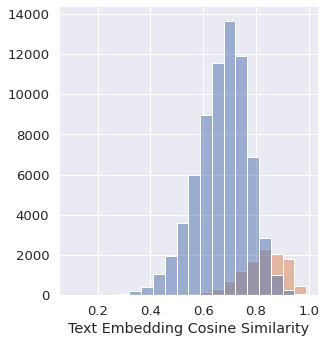

In [15]:
import pandas as pd

val_results = pd.read_csv('/work/adapting-CLIP-VGPs/eval/test_text_hm.csv')
plot = sns.displot(
    val_results,
    x="text_sim",
    bins=20,
    hue="ytrue",
    # multiple="stack"
    legend=None
)
plot.set_xlabels('Text Embedding Cosine Similarity')
plot.set(ylabel=None)